# u2001820 Powerlifting Project: Males vs Females
---
We aim to investigate the powerlifting dataset available on <a href="https://www.kaggle.com/datasets/open-powerlifting/powerlifting-database">Kaggle</a>.

This notebook is dedicated to exploring the differences between males and females in the world of powerlifting.

In [1]:
# imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ks_2samp

### Exploring the cleaned dataset

In [2]:
df = pd.read_csv("cleaned_powerlifting.csv")

In [3]:
len(df)

484944

In [4]:
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName
0,Abbie Murphy,F,SBD,Wraps,29.0,24-34,F-OR,59.8,60,80.0,...,324.16,286.42,511.15,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
1,Abbie Tuong,F,SBD,Wraps,29.0,24-34,F-OR,58.5,60,100.0,...,378.07,334.16,595.65,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
2,Amy Moldenhauer,F,SBD,Wraps,23.0,20-23,F-OR,60.0,60,-105.0,...,345.61,305.37,547.04,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
3,Andrea Rowan,F,SBD,Wraps,45.0,45-49,F-OR,104.0,110,120.0,...,338.91,274.56,550.08,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
4,April Alvarez,F,SBD,Wraps,37.0,35-39,F-OR,74.0,75,127.5,...,354.74,312.20,596.18,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup


In [5]:
df_filtered = df[['Name', 'Sex', 'Equipment', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 
               'TotalKg', 'Wilks', 'Tested']]

In [6]:
df_filtered.head()

,Name,Sex,Equipment,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Wilks,Tested
0,Abbie Murphy,F,Wraps,59.8,105.0,55.0,130.0,290.0,324.16,NaN
1,Abbie Tuong,F,Wraps,58.5,120.0,67.5,145.0,332.5,378.07,NaN
2,Amy Moldenhauer,F,Wraps,60.0,105.0,72.5,132.5,310.0,345.61,NaN
3,Andrea Rowan,F,Wraps,104.0,140.0,80.0,170.0,390.0,321.25,NaN
4,April Alvarez,F,Wraps,74.0,142.5,82.5,145.0,370.0,354.74,NaN


In [7]:
df_filtered['Equipment'].value_counts()

Equipment
Raw           214230
Single-ply    172240
Wraps          79311
Multi-ply      19163
Name: count, dtype: int64

For simplicity, we consider only contestants competing with `Single-ply`:

In [8]:
df_filtered = df_filtered[df_filtered['Equipment'] == 'Single-ply']

In [9]:
df_filtered.head()

,Name,Sex,Equipment,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Wilks,Tested
4980,Nathan Jones,M,Single-ply,109.0,385.0,195.0,330.0,910.0,537.05,NaN
6402,Patrizia Engeser,F,Single-ply,50.4,85.0,47.5,92.5,225.0,287.30,Yes
6404,Katja Haindl,F,Single-ply,56.7,100.0,50.0,85.0,235.0,273.82,Yes
6406,Fiona Feuerer,F,Single-ply,61.0,100.0,70.0,125.0,295.0,324.72,Yes
6408,Sonja Graumann,F,Single-ply,62.5,127.5,62.5,130.0,320.0,345.75,Yes


In [10]:
df_filtered['Tested'].value_counts()

Tested
Yes    161679
Name: count, dtype: int64

The `Tested` column determines whether the lifter has been tested for drug use or not. There are only two values in present in this column: `Yes` or NaN. In powerlifting, a 'natural' lifter is one who does not use Performance Enhancing Drugs, whereas those who do are referred to as 'enhanced'. Thus, any lifter with the value `Yes` in this column is most certainly a natural lifter, at least when tested in time for the competition. That said, just because a lifter has not been drug tested (value NaN), does not necessarily mean that said lifter is abusing drugs. To guarantee that we are dealing with natural athletes, we filter the data to ensure that `Tested = Yes`. So we now consider the remaining entrants are natural lifters.

In [11]:
df_filtered = df_filtered[df_filtered['Tested'] == 'Yes']

In [12]:
len(df_filtered)

161679

In [13]:
df_filtered['Name'].nunique()

46295

We have competitors with more than one entry in the dataset. This could be due to participants entering multiple competitions, for example. As such, we group records by the unique entrants, aggregating with the mean for their performance metrics in the three lifts:

In [14]:
df_filtered = df_filtered.groupby(['Name','Sex',
                       'Tested'])[['Best3SquatKg','Best3BenchKg',
                       'Best3DeadliftKg','TotalKg','BodyweightKg', 'Wilks']].mean().reset_index()

In [15]:
print(len(df_filtered))
# remove rows with missing values
df_filtered = df_filtered.dropna()
print(len(df_filtered))

46333
46261


In [16]:
df_filtered.head()

,Name,Sex,Tested,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,BodyweightKg,Wilks
0,A Abduzhabarov,M,Yes,155.0,110.0,170.0,435.0,74.00,312.90
1,A Ashwin,M,Yes,180.0,95.0,210.0,485.0,81.70,326.82
2,A Bauer,M,Yes,145.0,90.0,150.0,385.0,51.70,380.09
3,A Dilmuradov,M,Yes,95.0,50.0,115.0,260.0,59.90,222.09
4,A Dilymuradov,M,Yes,90.0,40.0,105.0,235.0,59.05,203.39


We devise our own `WeightClassKg` column to ensure consistency across all records of data:

In [17]:
df_filtered['WeightClassKg'] = df_filtered['BodyweightKg'].apply(float)

def weight_class(x):
    for i in range(10, 140, 10):
        if(x < i):
            return f"{str(i-10).zfill(3)} - {i} kg"
    return "130+ kg"
    
df_filtered['WeightClassKg'] = df_filtered['BodyweightKg'].apply( lambda x: weight_class(x))

In [18]:
df_filtered.head()

,Name,Sex,Tested,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,BodyweightKg,Wilks,WeightClassKg
0,A Abduzhabarov,M,Yes,155.0,110.0,170.0,435.0,74.00,312.90,070 - 80 kg
1,A Ashwin,M,Yes,180.0,95.0,210.0,485.0,81.70,326.82,080 - 90 kg
2,A Bauer,M,Yes,145.0,90.0,150.0,385.0,51.70,380.09,050 - 60 kg
3,A Dilmuradov,M,Yes,95.0,50.0,115.0,260.0,59.90,222.09,050 - 60 kg
4,A Dilymuradov,M,Yes,90.0,40.0,105.0,235.0,59.05,203.39,050 - 60 kg


Using the zero prefix before the two-digit weights in `NewWeightClassKg` allows us to order the values in this column by comparing digits from left to right.

We now construct a pivot table to understand the distribution of competitors across the weight classes by gender:

In [19]:
pivot_df = df_filtered.groupby(['WeightClassKg', 'Sex'])['TotalKg'].count().reset_index()
pivot_df.pivot_table(columns=['Sex'], index=['WeightClassKg'], values='TotalKg')

Sex,F,M
WeightClassKg,,
020 - 30 kg,6,4
030 - 40 kg,73,42
040 - 50 kg,1723,320
050 - 60 kg,3970,3690
060 - 70 kg,2707,4219
070 - 80 kg,1496,6092
080 - 90 kg,911,7312
090 - 100 kg,314,5105
100 - 110 kg,183,3607


In [20]:
len(df_filtered)

46261

In [21]:
df_filtered.to_csv('powerlifting_unique_individuals.csv', index=False)

### Removing outliers?

## Battle of the Sexes

In [22]:
# colours for plots
lred, dred, lblue, dblue = ["#fb9a99", "#e31a1c", "#a6cee3", "#1f78b4"]

males = df_filtered[df_filtered['Sex'] == 'M']['TotalKg']
females = df_filtered[df_filtered['Sex'] == 'F']['TotalKg']

In [23]:
print(min(females))
print(min(males))
print(max(males))
print(max(females))

40.8
78.25
1136.1538461538462
671.0757575757576


In [24]:
# distplots (no longer using)

# plt.close('all')
# plt.figure(figsize = (14, 6))
# sns.set_context("notebook", font_scale = 1.1)

# sns.distplot(males, label ='Male', color = dblue)
# sns.distplot(females, label ='Female', color = dred)
# # sns.histplot(males, label ='Male', kde=True, color = dblue)
# # sns.histplot(females, label ='Female', kde=True, color = dred)
# plt.legend()

# plt.title("Histograms of Total Kg Lifted by Gender")
# #plt.yticks([])
# plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900])
# plt.xlim(50, 950)
# plt.xlabel('Total Kg Lifted')
# plt.ylabel('Density')
# plt.show()

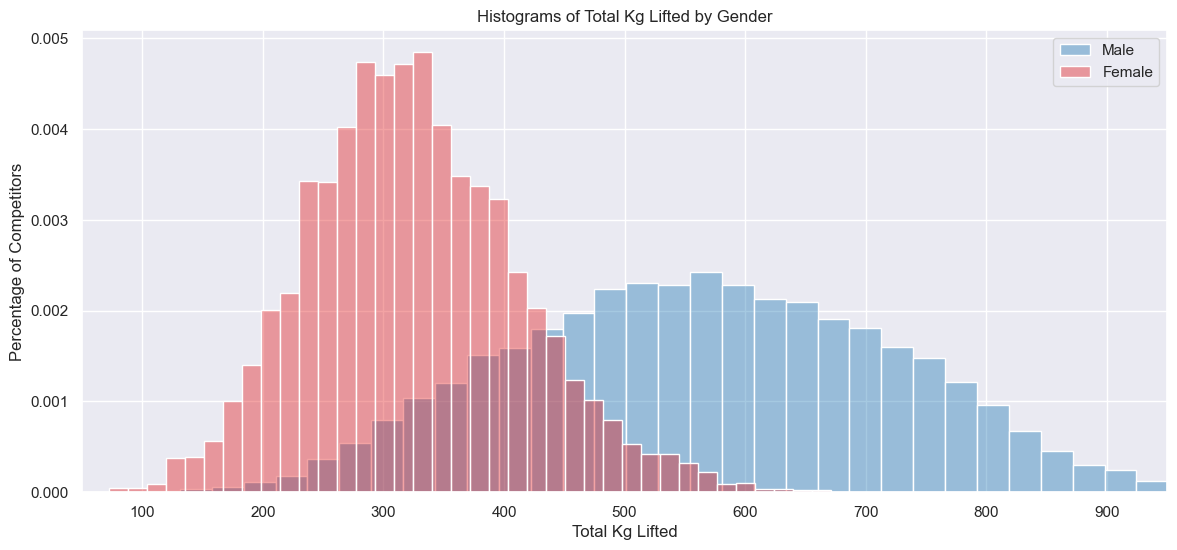

In [25]:
plt.close('all')
plt.figure(figsize = (14, 6))
sns.set()
# sns.set_context("notebook", font_scale = 1.1)

sns.histplot(males, label ='Male', stat='density', alpha=0.4, color = dblue,  bins=40)
sns.histplot(females, label ='Female', stat='density', alpha=0.4, color = dred,  bins=40)
plt.legend()

plt.title('Histograms of Total Kg Lifted by Gender')
#plt.yticks([])
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900])
plt.xlim(50, 950)
plt.xlabel('Total Kg Lifted')
plt.ylabel('Percentage of Competitors')
plt.show()

We utilise Scipy's `percentileofscore` function to evaluate what percentage of females powerlifters can be beat by the average male powerlifter and vice versa:

In [26]:
female_mean = females.mean()
male_mean = males.mean()

Mean_male_v_females = stats.percentileofscore(females, male_mean)
Mean_female_v_males = stats.percentileofscore(males, female_mean)
print(f'Average Female Total: {round(female_mean, 2)}kg')
print(f'Average Male Total: {round(male_mean, 2)}kg')
print()
print(f'The average male powerlifter is stronger than {round(Mean_male_v_females, 2)}% of female powerlifters.')
print(f'The average female powerlifter is stronger than {round(Mean_female_v_males, 2)}% of male powerlifters.')

Average Female Total: 325.42kg
Average Male Total: 565.14kg

The average male powerlifter is stronger than 99.27% of female powerlifters.
The average female powerlifter is stronger than 6.38% of male powerlifters.


In the above, we have compared the average male performance to the series of females and vice versa. Let us now formulate the problem in a more probabilistic manner to ascertain the strength of a male competitor **chosen at random** (i.e. not the average this time) compared to the series of females.

We achieve this using z-scores. In particular, we consider the distribution of the difference between the male and female lifts. Suppose that $M$ is a random variable following the distribution of total kg lifted by males, and $F$ similar for females. Then the random variable representing the difference in total kg lifted between males and females is given by $D = M - F$. We cannot simply subtract the two Series from each other for the value of $D$. However, we can compute the mean and the variance of $D$. For the former, $\mu_D = \mu_M - \mu_F$. For the latter, we have by the independence between the male and female data, we have that $\sigma_D^2$ = $\sigma_M^2$ + $\sigma_F^2$.

In [27]:
# find the mean of the difference distribution r.v.
diff_mean = males.mean() - females.mean()

# find the variance of the distribution r.v.
diff_var = males.std()**2 + females.std()**2
diff_std = np.sqrt(diff_var)

print(f"The average difference between male and female total weight lifted is {round(diff_mean, 2)}kg.")
print(f"The standard deviation of the difference is {round(diff_std, 2)}kg.")

The average difference between male and female total weight lifted is 239.72kg.
The standard deviation of the difference is 179.36kg.


We now model the distribution of the random variable $D$ as a Gaussian with the parameters above. Then if $D>0$, we have the case where the r.v. for the male exceeds the r.v. of the female and so the male has a higher total weight lifted. Conversely, if $D<0$, then the r.v. for the female is able to lift more.

0.0


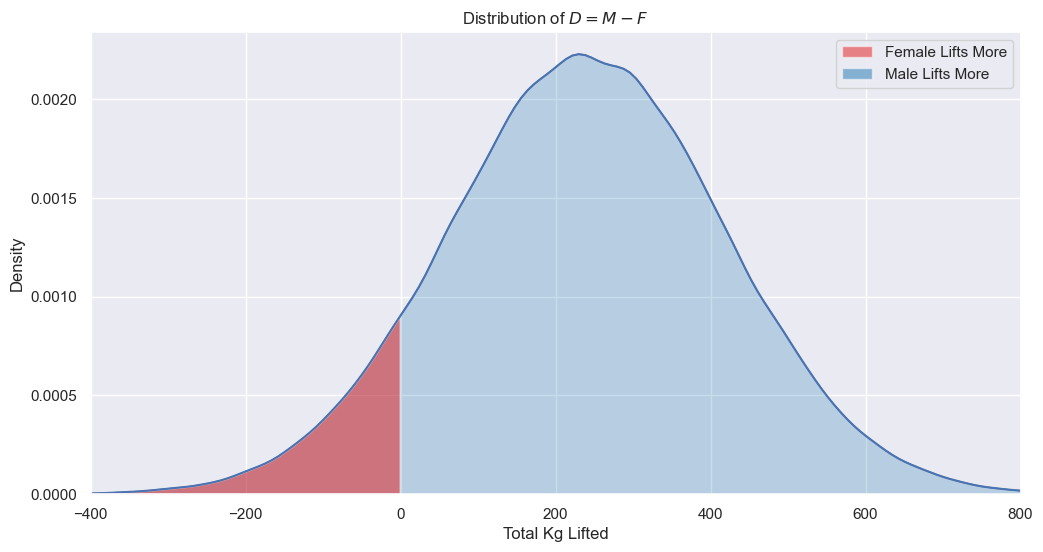

In [28]:
diff_dist = np.random.normal(diff_mean, diff_std, size=100000)
plt.figure(figsize = (12, 6))
sns.set()
# sns.set_context("notebook", font_scale = 1.1)

sns.kdeplot(diff_dist, color = dblue, fill = True)
# create an object to reference
ax = sns.kdeplot(diff_dist)
x, y = ax.get_lines()[-1].get_data()

# shading in female-dominant area using mask on kde
mask = x <= 0
x, y = x[mask], y[mask]
ax.fill_between(x, y1=y, alpha=0.5, facecolor= dred, label = 'Female Lifts More')

# shading in male-dominant area using mask on kde
mask = x > 0

# for later
x, y = x[mask], y[mask]
ax.fill_between(x, y1=y, alpha=0.5, facecolor= dblue, label = 'Male Lifts More')

plt.title('Distribution of $D = M - F$')
plt.legend()
plt.xlabel('Total Kg Lifted')

plt.xlim(-400, 800)

area = np.trapz(y, x)
print(area)

plt.show()


We can now evaluate the desired probability by using the z-score $z = \frac{X-\mu}{\sigma}$:

In [29]:
z = 0-diff_mean/diff_std
print(z)

-1.3365692734653694


In [30]:
p_female = stats.norm.cdf(z)
p_male = 1 - p_female

In [31]:
print("Selecting a male competitor and female competitor at random:")
print(f"The probability that the female is stronger than the male is: {round(p_female*100,2)}%.")
print(f"The probability that the male is stronger than the female is: {round(p_male*100,2)}%.")

Selecting a male competitor and female competitor at random:
The probability that the female is stronger than the male is: 9.07%.
The probability that the male is stronger than the female is: 90.93%.


The above investigation backs up scientific claims that men have more physical strength than women (due to biology, hormones, etc.).

### Wilks coefficient comparison

We now compare males and females using the Wilks formula.

In [32]:
males_wilks = df_filtered[df_filtered['Sex'] == 'M']['Wilks']
females_wilks = df_filtered[df_filtered['Sex'] == 'F']['Wilks']

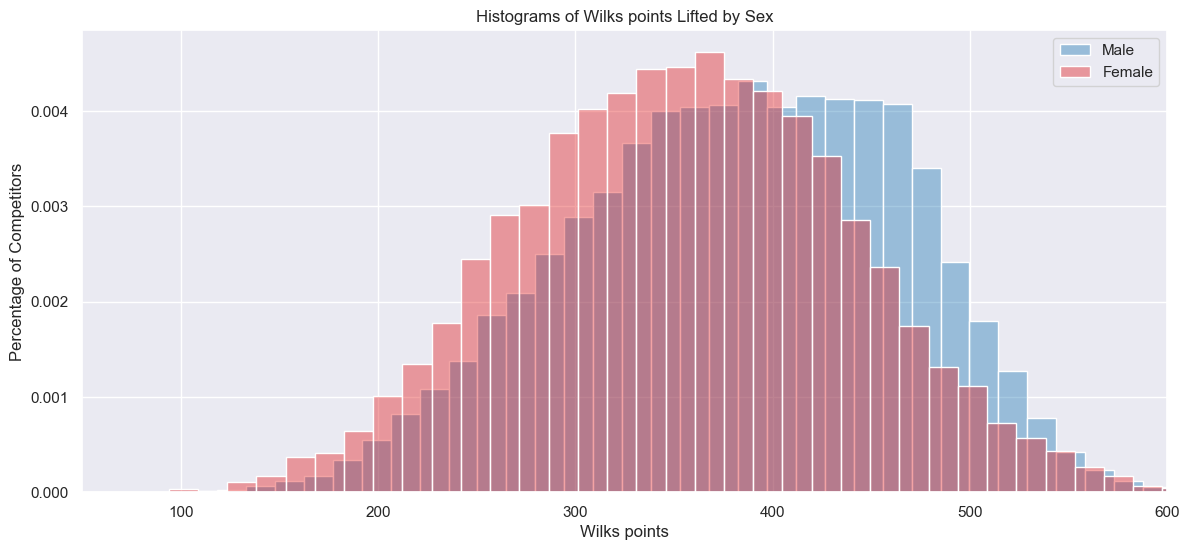

In [60]:
# histplot version (not deprecated)
plt.close('all')
plt.figure(figsize = (14, 6))
sns.set()
# sns.set_context("notebook", font_scale = 1.1)

sns.histplot(males_wilks, label ='Male', stat='density', alpha=0.4, color = dblue,  bins=40)
sns.histplot(females_wilks, label ='Female', stat='density', alpha=0.4, color = dred,  bins=40)
plt.legend()

plt.title('Histograms of Wilks points Lifted by Sex')
#plt.yticks([])
plt.xticks([0, 100, 200, 300, 400, 500, 600])
plt.xlim(50, 600)
plt.xlabel('Wilks points')
plt.ylabel('Percentage of Competitors')
plt.show()

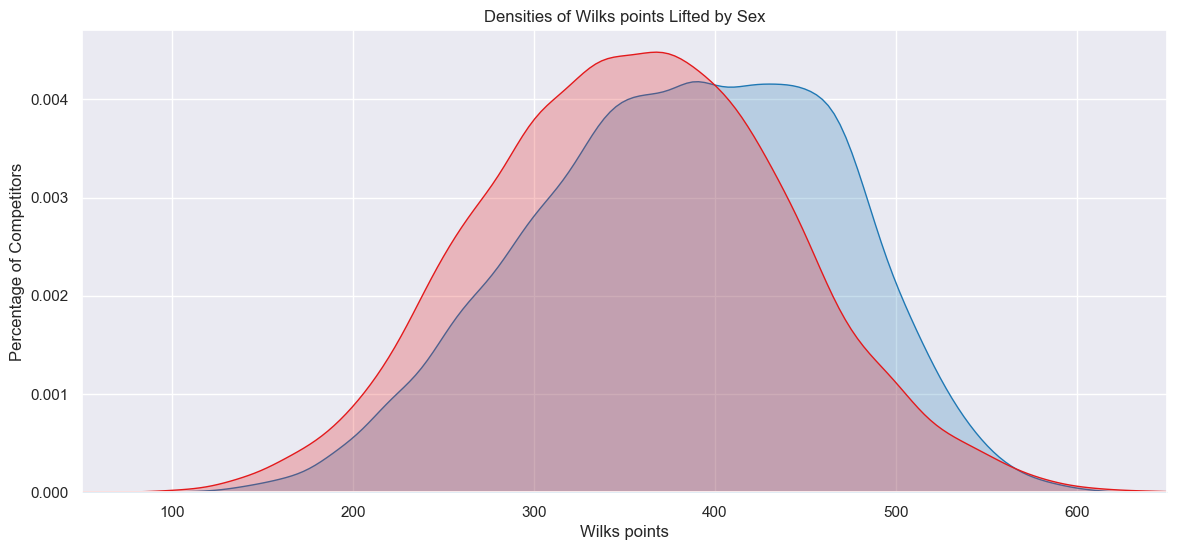

In [61]:
plt.figure(figsize = (14, 6))
sns.kdeplot(males_wilks, label='Natural', fill=True, color = dblue)
sns.kdeplot(females_wilks, label='Not tested', fill=True, color = dred)

plt.title('Densities of Wilks points Lifted by Sex')
#plt.yticks([])
plt.xticks([0, 100, 200, 300, 400, 500, 600])
plt.xlim(50, 650)
plt.xlabel('Wilks points')
plt.ylabel('Percentage of Competitors')
plt.show()

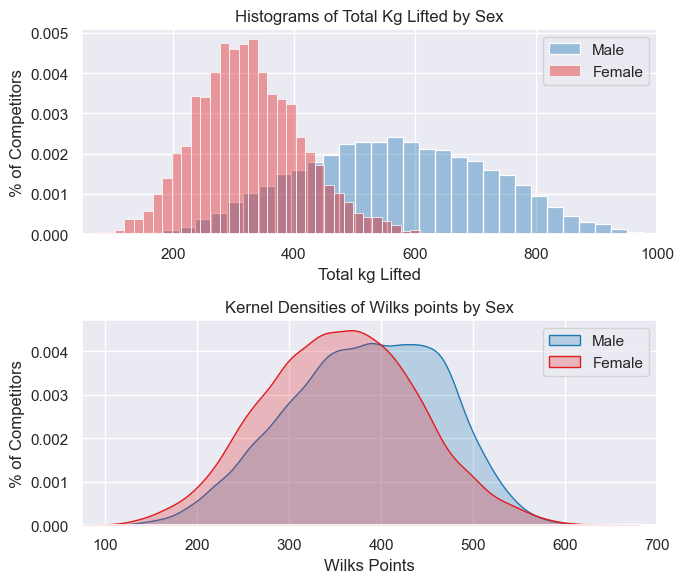

In [62]:
# subplots for report
sns.set()
fig, axes = plt.subplots(2, 1, figsize=(7, 6))
sns.histplot(males, label ='Male', stat='density', alpha=0.4, color = dblue,  bins=40, ax=axes[0])
sns.histplot(females, label ='Female', stat='density', alpha=0.4, color = dred,  bins=40, ax=axes[0])
axes[0].set_title('Histograms of Total Kg Lifted by Sex')
axes[0].set_xlabel('Total kg Lifted')
axes[0].set_ylabel('% of Competitors')
axes[0].set_xlim(50, 1000)
axes[0].legend()


sns.kdeplot(males_wilks, label='Male', fill=True, color = dblue, ax=axes[1])
sns.kdeplot(females_wilks, label='Female', fill=True, color = dred, ax=axes[1])
axes[1].set_title('Kernel Densities of Wilks points by Sex')
axes[1].set_xlabel('Wilks Points')
axes[1].set_ylabel('% of Competitors')
axes[1].set_xlim(75, 700)
axes[1].legend()


plt.tight_layout()
plt.show()